# Chapter 5 - Computer Vision Anomaly Explainability

Computer vision-based visual anomaly detection has broad applications, such as industrial manufacturing, medical imaging analysis, and autonomous driving. Detecting anomalies in image data is challenging yet crucial to identify abnormal events, safety risks, and quality defects that result in financial and brand damage to many companies.

This notebook covers a visual anomaly detection using VGG16 convolutional neural network and a [chest X-Ray pneumonia image dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) available at Kaggle. You can experiment with this example on [Amazon SageMaker Studio Lab](https://aws.amazon.com/sagemaker/studio-lab/), a free notebook development environment that provides up to 12 hours of CPU or 4 hours of GPU per user session and 15GiB storage at no cost. Alternatively, you can try this on your preferred Integrated Development Environment (IDE).

## Setup

In [2]:
import sys
!{sys.executable} -m pip install -qr requirements.txt

In [3]:
# Load essential libraries

import cv2
import os
import re
import glob
import random
import warnings
import numpy as np 
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
from platform import python_version
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, ImageDataGenerator


warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print(f'TensorFlow version: {tf.__version__}')
print(f'Python version: {python_version()}')

TensorFlow version: 2.9.2
Python version: 3.9.10


# Load Images

In [4]:
# Set dataset path, input shape, and batch size
%matplotlib inline

base_path = "images/chest_xray/"
train_path = base_path + "train/"
test_path = base_path + "test/"
val_path = base_path + "val/"

SHAPE = (224,224,3)
batch_size = 256
classes = ["NORMAL", "PNEUMONIA"]

print(f'train_path: {train_path}')
print(f'test_path: {test_path}')
print(f'val_path: {val_path}')

train_path: images/chest_xray/train/
test_path: images/chest_xray/test/
val_path: images/chest_xray/val/


In [5]:
# Function to load images

def load_image_data(path, label):
    images = []
    for img_path in glob.glob(path + label + '/*.jpeg'):
        images.append(mpimg.imread(img_path))
        if len(images)>4:
                break

    fig = plt.figure(figsize=(25, 10))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(round(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image, aspect='auto')
        plt.title(label)

Can you tell the differences between the two classes? According to the dataset description, normal chest X-ray images typically show clear lungs without opacification or cloudiness. Bacteria pneumonia displays a focal lobar consolidation in one of the lobes of the lung. Viral pneumonia shows a more diffuse interstitial pattern surrounding both lungs.

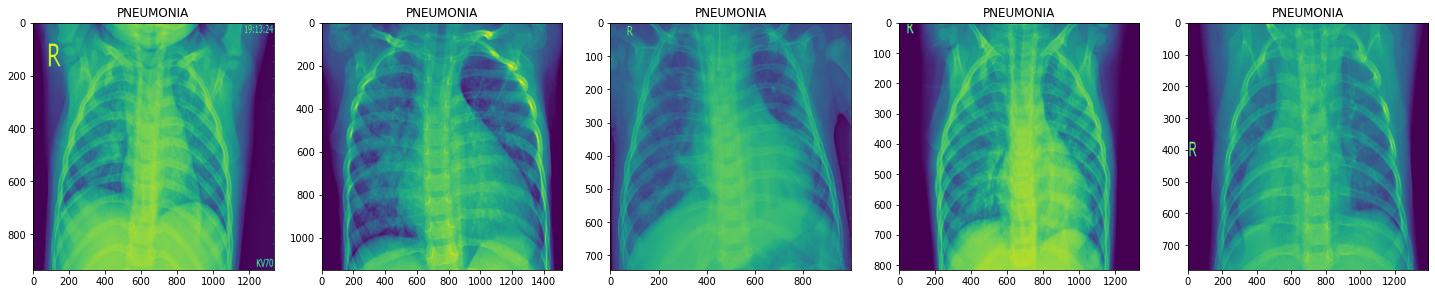

In [6]:
# Visualize sample pneumonia images
load_image_data(train_path, classes[1])

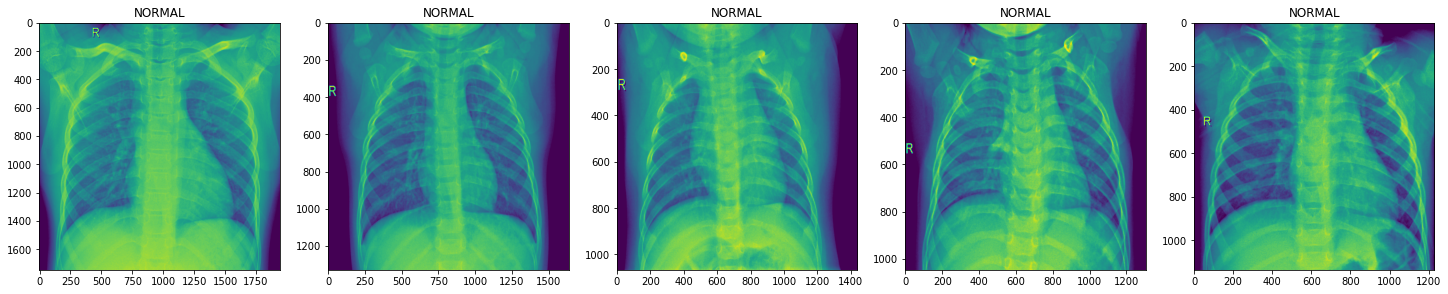

In [7]:
# Visualize sample normal images
load_image_data(train_path, classes[0])

## Load and Train Model

In [8]:
# Function to load VGG16 model

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    
def get_model():
    
    set_seed(33)
    
    vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = SHAPE)

    for layer in vgg.layers[:-8]:
        layer.trainable = False

    x = vgg.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation="softmax")(x)

    model = Model(vgg.input, x)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])
    
    return model

In [9]:
# Generate batches of tensor image data with real-time data augmentation to rescale the image.

train_datagen = ImageDataGenerator(
        rescale=1/255
)

test_datagen = ImageDataGenerator(
        rescale=1/255
)

val_datagen = ImageDataGenerator(
        rescale=1/255
)

In [10]:
# Read images from a directory and augment them while the neural network model is learning on the training data.

train_generator = train_datagen.flow_from_directory(
            train_path,
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            subset = None,
            seed = 33
)

test_generator = test_datagen.flow_from_directory(
            test_path,
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            subset = None,
            seed = 33
)

val_generator = val_datagen.flow_from_directory(
            val_path,
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            subset = None,
            seed = 33
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [11]:
# Retrieve test label from generator 

test_num = test_generator.samples

label_test = []
for i in range((test_num // test_generator.batch_size)+1):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)

label_test.shape

(624,)

In [12]:
# Load and fit model

model = get_model()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
# Start the training

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=8
)

Epoch 1/8
20/20 [==============================] - 244s 12s/step - loss: 0.5509 - accuracy: 0.7429
Epoch 2/8
20/20 [==============================] - 243s 12s/step - loss: 0.5010 - accuracy: 0.7429
Epoch 3/8
20/20 [==============================] - 242s 12s/step - loss: 0.4415 - accuracy: 0.7500
Epoch 4/8
20/20 [==============================] - 244s 12s/step - loss: 0.3763 - accuracy: 0.8202
Epoch 5/8
20/20 [==============================] - 245s 12s/step - loss: 0.3097 - accuracy: 0.8921
Epoch 6/8
20/20 [==============================] - 244s 12s/step - loss: 0.2551 - accuracy: 0.9112
Epoch 7/8
20/20 [==============================] - 245s 12s/step - loss: 0.2152 - accuracy: 0.9220
Epoch 8/8
20/20 [==============================] - 245s 12s/step - loss: 0.1901 - accuracy: 0.9293


## Evaluate Model
Let's create a classification report and confusion matrix to evaluate performance on test data.

In [14]:
# Create report to show classification metrics

print(classification_report(label_test, np.argmax(model.predict(test_generator),axis=1)))

3/3 [==============================] - 16s 4s/step
              precision    recall  f1-score   support

           0       0.93      0.51      0.66       234
           1       0.77      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.85      0.74      0.76       624
weighted avg       0.83      0.80      0.78       624



In [15]:
# Obtain predictions for test data

y_preds = np.argmax(model.predict(test_generator),axis=1)

3/3 [==============================] - 16s 4s/step


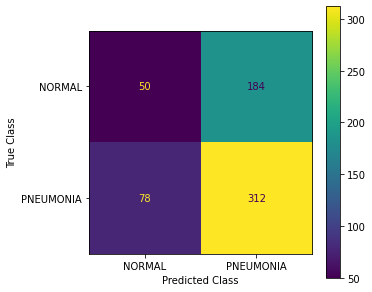

In [16]:
# Create a confusion matrix

cm = confusion_matrix(label_test, y_preds)

cmp = ConfusionMatrixDisplay(cm, display_labels=classes)

fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.savefig("pneumonia_confusion_matrix.png", bbox_inches='tight')

# Create Activation Maps

We can visualize discriminative image regions that CNN uses to identify the target image label using class activation map(CAM).

In [17]:
# Function to plot activations

def plot_activation(img):
  
    pred = model.predict(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)

    weights = model.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]

    intermediate = Model(model.input, model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)

    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])

    activation_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(activation_maps.reshape((img.shape[0]*img.shape[1], 512)), class_weights).reshape(
        img.shape[0],img.shape[1])

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3), aspect='auto')
    plt.imshow(out, cmap='jet', alpha=0.35, aspect='auto')
    plt.title('Pneumonia' if pred_class == 1 else 'Normal')

1/1 [==============================] - 0s 124ms/step


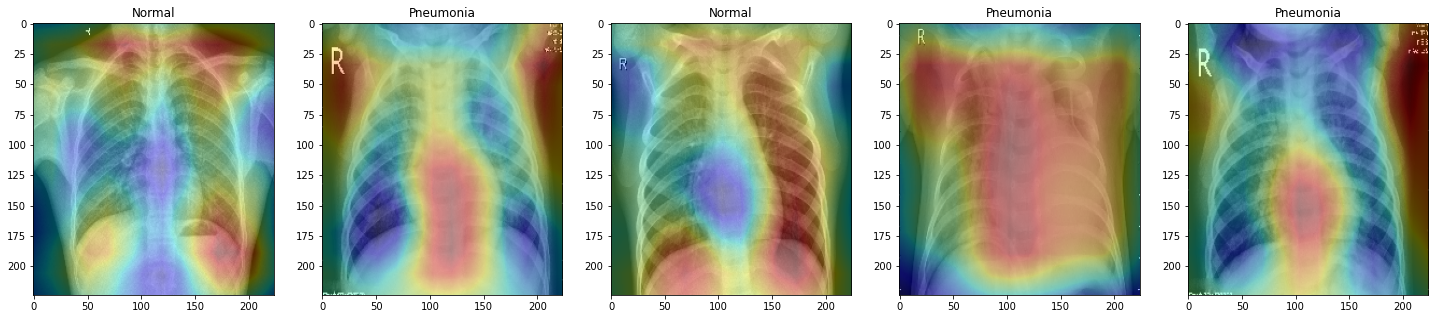

In [18]:
# Visualize heatmaps for sample test images

fig = plt.figure(figsize=(25, 5))

rows = 1
columns = 5

for i in range(5):
    fig.add_subplot(rows, columns, i+1)
    plot_activation(X[i])

# Grad-CAM

Here, we will visualize activations using Grad-CAM.

In [19]:
# Load test images. Classes 0 is NORMAL and 1 is PNEUMONIA

pneumonia_data_dir = test_path + classes[1]
normal_data_dir = test_path + classes[0]

gradcam_test_pneumonia = []
gradcam_test_normal = []

def load_gradcam_images(data_dir, output_list):
    for x in os.listdir(data_dir):
        if x.endswith(".jpeg"):
            filename = os.path.join(data_dir, x)
            output_list.append(filename)

load_gradcam_images(pneumonia_data_dir, gradcam_test_pneumonia)
load_gradcam_images(normal_data_dir, gradcam_test_normal)

In [20]:
# Set image size and intermediate layer

img_size = SHAPE
intermediate_conv_layer_name = "block5_conv3"

# Preprocesses a tensor or Numpy array encoding a batch of images.

preprocess_input = keras.applications.vgg16.preprocess_input

In [21]:
# Preprocess input image

def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


# Map the input image to the intermediate layer and compute gradients to show activation corresponding to the intermediate layer's feature map. 

def make_gradcam_heatmap(img_array, model, intermediate_conv_layer_name, pred_index=None):
   
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(intermediate_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


## Generate Heatmaps

In [22]:
# Prepare image, Remove last layer's softmax, Generate class activation heatmap, display heatmap

model = model

heatmaps_pneumonia = []
heatmaps_normal = []

def create_heatmap(images, heatmap_path):
    img_array = preprocess_input(get_img_array(images, size=img_size))
    model.layers[-1].activation = None
    heatmap = make_gradcam_heatmap(img_array, model, intermediate_conv_layer_name)
    heatmap_path.append(heatmap)

In [23]:
# Preprocess test images, rescale heatmap to a range 0-255, use RGB for colormap, superimpose heatmap over original test images
import matplotlib.cm as cm

gradcam_pneumonia_images = []
gradcam_normal_images = []

#def save_and_display_gradcam(img_path, heatmap, cam_path="gradcam.jpg", alpha=0.4):

def save_and_display_gradcam(img_path, heatmap, output_path, alpha=0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    output_path.append(superimposed_img)

## Grad-CAM for PNEUMONIA class.

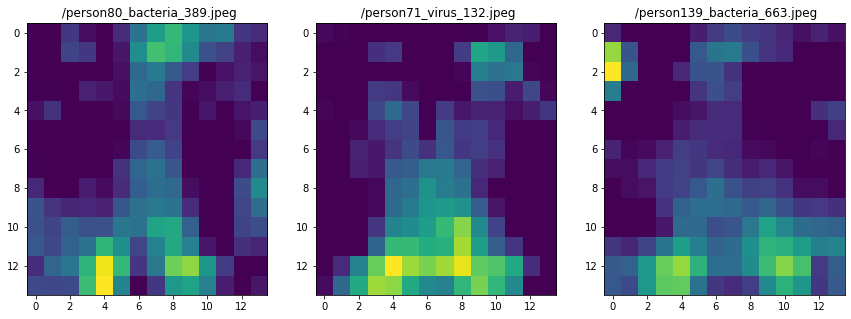

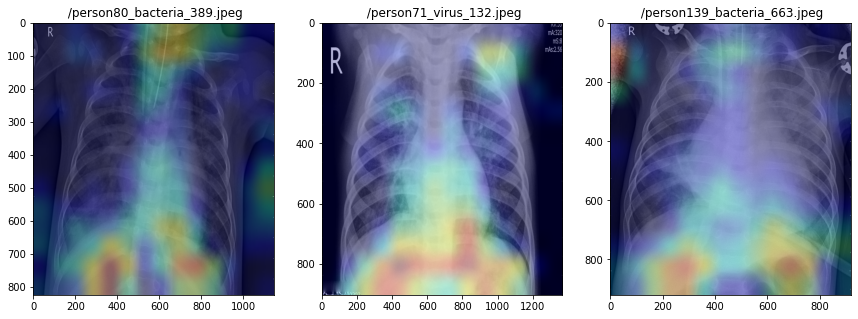

In [24]:
# Visualize heatmaps

fig = plt.figure(figsize=(25, 5))

for i in range(3):
    create_heatmap(gradcam_test_pneumonia[i], heatmaps_pneumonia)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(heatmaps_pneumonia[i], aspect='auto')
    plt.title(re.sub(pneumonia_data_dir, " ",gradcam_test_pneumonia[i]))

fig = plt.figure(figsize=(25, 5))

for i in range(3):
    save_and_display_gradcam(gradcam_test_pneumonia[i], heatmaps_pneumonia[i], gradcam_pneumonia_images)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(gradcam_pneumonia_images[i], aspect='auto')
    plt.title(re.sub(pneumonia_data_dir, " ",gradcam_test_pneumonia[i]))

## Grad-CAM for NORMAL class.

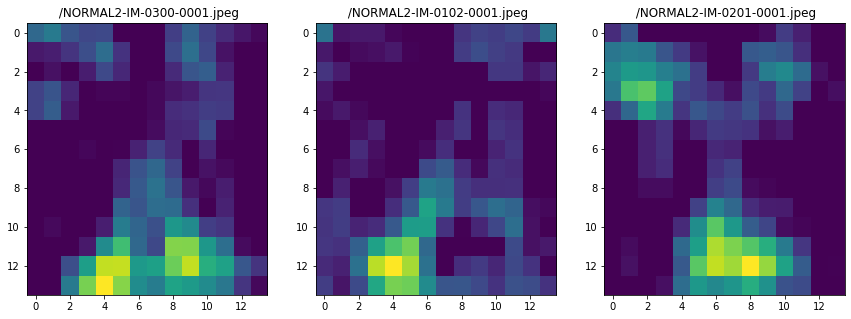

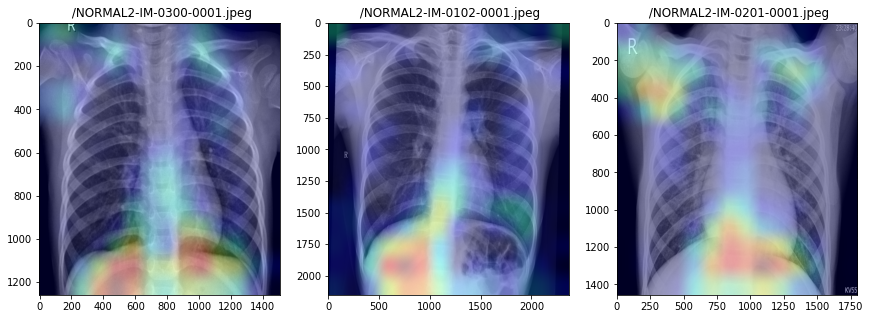

In [25]:
fig = plt.figure(figsize=(25, 5))

for i in range(3):
    create_heatmap(gradcam_test_normal[i], heatmaps_normal)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(heatmaps_normal[i], aspect='auto')
    plt.title(re.sub(normal_data_dir, " ",gradcam_test_normal[i]))
    
fig = plt.figure(figsize=(25, 5))

for i in range(3):
    save_and_display_gradcam(gradcam_test_normal[i], heatmaps_normal[i], gradcam_normal_images)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(gradcam_normal_images[i], aspect='auto')
    plt.title(re.sub(normal_data_dir, " ",gradcam_test_normal[i]))

This concludes our walkthrough of saliency maps. You can try to replace the image dataset and pre-trained models.